In [1]:
import os

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Omniglot
from torchvision.transforms.functional import to_pil_image
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T


In [2]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 5),
            nn.ReLU(),
            nn.Flatten(1)
        )
        self.linear1 = nn.Linear(8192, 4096)
        self.linear2 = nn.Linear(4096, 1)

    def forward_one(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.linear1(x)

        x = F.sigmoid(x)
        return x
    
    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.forward_one(x1)
        x2 = self.forward_one(x2)
        dist = torch.abs(x1 - x2)
        out = self.linear2(dist)
        return out



In [3]:
# For testing outputs

# net = Siamese()
# # Samples in Omniglot is [1, 105, 105]
# x1 = torch.rand([1, 1, 64, 64])
# out = net.forward_one(x1)
# print(out)

In [4]:
BATCH_SIZE = 96
NUM_WORKERS = 16
RESIZE = (64, 64)

In [5]:
transform_train = T.Compose([T.RandomResizedCrop(RESIZE, scale=(0.6, 1.0)), T.RandomAffine(15, fill=1.), T.ToTensor()])
transform_test = T.Compose([T.Resize(RESIZE), T.ToTensor()])

omniglot_bg = Omniglot(root='./data/omniglot', background=True, transform=transform_train, download=True)
omniglot_eval = Omniglot(root='./data/omniglot', background=False, transform=transform_test, download=True)

print(f'# of training samples: {len(omniglot_bg)}')
print(f'# of test samples:     {len(omniglot_eval)}')

Files already downloaded and verified
Files already downloaded and verified
# of training samples: 19280
# of test samples:     13180


In [6]:
import matplotlib.pyplot as plt

def show(imgs):
    """Show images"""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Files already downloaded and verified
torch.Size([1, 105, 105])


/home/lukec/workspace/pygeo_playground/venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


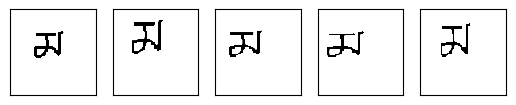

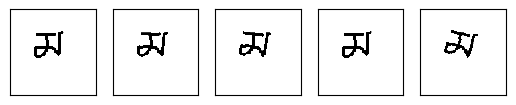

In [7]:
raw_data = Omniglot(root='./data/omniglot', background=False, transform=T.Compose([T.ToTensor()]), download=True)
img = raw_data[0][0]
print(img.size())
images = [img]
for i in range(4):
    images.append(T.RandomResizedCrop(RESIZE, scale=(.6, 1.0))(img))
show(images)

images = [img]
for i in range(4):
    images.append(T.RandomAffine(15, fill=1.)(img))
show(images)

In [8]:
class OmniglotTrain(Dataset):
    """A customized dataset that returns a pair. The support label matches the
    query label based on the rate parameter `r`.
    """
    def __init__(self, dataset, r=0.5):
        super(OmniglotTrain, self).__init__()

        self.dataset = dataset
        self.r = r
        self.load_lookup()

    def load_lookup(self):
        """Build positive and negative indices lookup table for all classes"""
        self.lookup = {}
        labels = [sample[1] for sample in self.dataset]
        unique_labels = np.unique(labels)
        for lbl in unique_labels:
            indices_pos = [i for i, _lbl in enumerate(labels) if _lbl == lbl]
            indices_neg = [i for i in range(len(self)) if i not in indices_pos]
            self.lookup[lbl] = (indices_pos, indices_neg)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        draw = torch.rand(1).item()
        query = self.dataset[index]
        lbl_true = query[1]
        if draw <= self.r:  # Return a positive pair
            idx_support = np.random.choice([i for i in self.lookup[lbl_true][0] if i != index], 1)[0]
            output = 1  # If match return 1, else return 0.
        else:  # Return a negative pair
            idx_support = np.random.choice(self.lookup[lbl_true][1], 1)[0]
            output = 0
        support = self.dataset[idx_support]
        return query[0], support[0], torch.Tensor([output]), (query[1], support[1])

In [9]:
class OmniglotQuery(Dataset):
    """A customized dataset that returns 20-way 1-shot query and support tuple.
    """
    def __init__(self, dataset, num_ways=20):
        super(OmniglotQuery, self).__init__()

        self.dataset = dataset
        self.num_ways = num_ways
        self.load_lookup()

    def load_lookup(self):
        """Build positive and negative indices lookup table for all classes
        self.lookup[label][0]: indices of examples with matching the label.
        self.lookup[label][1]: indices of any other examples.
        """
        self.lookup = {}
        labels = [sample[1] for sample in self.dataset]
        unique_labels = np.unique(labels)
        for lbl in unique_labels:
            indices_pos = [i for i, _lbl in enumerate(labels) if _lbl == lbl]
            indices_neg = [i for i in range(len(self)) if i not in indices_pos]
            self.lookup[lbl] = (indices_pos, indices_neg)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        """Compute support that only contains 1 aligned example. """
        query = self.dataset[index]
        lbl_true = query[1]
        idx_match = np.random.choice([i for i in self.lookup[lbl_true][0] if i != index], 1)
        # The rest of examples should NOT match the true label
        idx_support = np.random.choice(self.lookup[lbl_true][1], self.num_ways - 1)
        # Combine 1 matched and rest unmatched indices
        indices = np.random.permutation(np.concatenate([idx_match, idx_support]))
        assert len(indices) == self.num_ways, 'Support does not match n_ways!'
        support_x = torch.stack([self.dataset[i][0] for i in indices])
        support_y = torch.LongTensor([self.dataset[i][1] for i in indices])
        # Return: x_query, x_supports, y_query, y_supports
        return query[0], support_x, query[1], support_y
        

In [10]:
dataset_train = OmniglotTrain(omniglot_bg)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

dataset_test = OmniglotTrain(omniglot_eval)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [11]:
class OmniglotModule(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        super(OmniglotModule, self).__init__()
        self.model = model
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.save_hyperparameters(ignore=['model'])  # Do not save the entire model!

    def forward(self, x1, x2):
        return self.model(x1, x2)
    
    def configure_optimizers(self):
        # optimizer = torch.optim.SGD(
        #     self.model.parameters(),
        #     lr=self.hparams.lr,
        #     momentum=0.9,
        # )
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x1 , x2, match, _ = batch
        output = self(x1, x2)
        loss = self.loss_fn(output, match)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self.__evaluate(batch)
        self.log('validation_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.__evaluate(batch)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def __evaluate(self, batch):
        x1 , x2, match, _ = batch
        output = self(x1, x2)
        loss = self.loss_fn(output, match)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x_query, x_supports, y_query, y_supports = batch
        batch_size = x_query.size(0)
        support_size = x_supports.size(1)
          # Set everything to a dummy label `-1`
        predictions = -torch.ones(batch_size).to(torch.long).to(self.device)
        for i in range(batch_size):
            query = x_query[i]
            repeated_query = query.repeat(support_size, 1, 1, 1)
            outputs = F.sigmoid(self(repeated_query, x_supports[i]))
            pred_idx = torch.argmax(outputs)  # Find support
            pred_lbl = y_supports[i][pred_idx]  # Find support's label
            predictions[i] = pred_lbl
        # Combine prediction and true labels as column vectors [pred, true]
        return torch.stack([predictions, y_query]).T
        

In [12]:
# Load pre-trained model
# VISION = '0'
# CHECKPOINT_FILE = 'epoch=49-step=10050.ckpt
# PATH_CHECKPOINT = os.path.join(os.getcwd(), 'lightning_logs', f'version_{VISION}', 'checkpoints', CHECKPOINT_FILE)

# net = Siamese()
# if os.path.exists(PATH_CHECKPOINT):
#     siamese_net = OmniglotModule.load_from_checkpoint(PATH_CHECKPOINT, model=net)

# trainer = pl.Trainer(accelerator='gpu', enable_progress_bar=True, precision='16-mixed')

In [13]:
# Train model
MAX_EPOCH = 50

net = Siamese()
siamese_net = OmniglotModule(net)
trainer = pl.Trainer(max_epochs=MAX_EPOCH, accelerator='gpu', enable_progress_bar=True, precision='16-mixed')
trainer.fit(siamese_net, loader_train, loader_test)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lukec/workspace/pygeo_playground/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for pe

Epoch 49: 100%|██████████| 201/201 [00:08<00:00, 24.03it/s, v_num=0, validation_loss=0.191, train_loss=0.147]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 201/201 [00:08<00:00, 22.59it/s, v_num=0, validation_loss=0.191, train_loss=0.147]


In [14]:
dataset_query = OmniglotQuery(omniglot_eval)
loader_query = DataLoader(dataset_query, batch_size=100, shuffle=False, num_workers=NUM_WORKERS)

In [15]:
predictions = torch.concat(trainer.predict(siamese_net, dataloaders=loader_query))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 132/132 [00:23<00:00,  5.74it/s]


In [16]:
def accuracy(predictions):
    """Compute accuracy"""
    pred = predictions[:, 0]  # 1st column
    y_true = predictions[:, 1]  # 2nd column
    return torch.sum(pred == y_true) / pred.size(0)

In [17]:
acc = accuracy(predictions)

print(f'Accuracy on 20way-1shot is: {acc*100:.2f}')

Accuracy on 20way-1shot is: 79.70
